# In this notebook we present a solution to the [Personalized Medicine: Redefining Cancer Treatment](https://www.kaggle.com/c/msk-redefining-cancer-treatment) competition on Kaggle

## ** The problem: ** 

  #### <ol> We are provided with "training" data which contains many genes, variants, and so called classes, and along with this information we are given a text file, which usually appears to be a scientific paper. We are then tasked with building a classifier which can determine the class of a given gene, mutation and corresponding text file. The trouble is that we are not told what the classes mean so we have to determine a classifier which can determine a likelihood of what the classes mean by looking at the provided data associated with each class. We are also given "test" data which consists of a gene, variation, and text. The test data provided is quite different from the training data. 
  

## **Our Approach:**

  #### <ol> We approach the problem using a random forest classifier. For a discussion on how this classifier works please see [classifier summary](https://github.com/cwine/MSK-Project/blob/master/classifier.pdf)
    
## **Results:**

  #### <ol> After submitting our solution to Kaggle (which scored the submission based on a subset of the data) we received a log-loss score of 5.085, which is only slightly worse than we received on our "test" data, where we knew the answer beforehand. The log-loss is calculated by taking the average of the negative of the sum of the log values of the predicted probability in the correct class. That means that predicting a high probability for the correct class will add only a small amount to the log-loss whereas predicting a low probability in the correct class will add a larger amount to the log-loss. For example if in row 5 (out of 968) one were to predict the probability of class 3 to be 0.2 then -log(0.2) = 1.609 would be added to log-loss, and 1 would be added to the denominator, so predicting a low probability in the correct class will add a bigger impact to log-loss. 

In [12]:
from pathlib import Path

import pandas as pd
import numpy as np
import sklearn

In [13]:
variants_train=pd.read_csv('/Users/cory/Desktop/Kaggle/msk/training_variants.txt',index_col=0,verbose=True)

Tokenization took: 2.14 ms
Type conversion took: 21.38 ms
Parser memory cleanup took: 4.68 ms


In [15]:
variants_test= pd.read_csv('/Users/cory/Desktop/Kaggle/all/stage2_test_variants.csv',index_col=0,verbose=True)

Tokenization took: 0.12 ms
Type conversion took: 0.65 ms
Parser memory cleanup took: 0.00 ms


In [16]:
text_train = pd.read_table('/Users/cory/Desktop/Kaggle/msk/training_text.txt',sep='\|\|',engine='python',verbose=True)

Filled 5 NA values in column ID,Text


In [19]:
text_train.columns=['Text']
text_test= pd.read_table('/Users/cory/Desktop/Kaggle/all/stage2_test_text.csv',sep='\|\|',engine='python',verbose=True)
text_test.index.names=['Id']
text_test.columns = ['Text']

In [20]:
text_test = text_test.replace(np.nan,'',regex=True)
text_train = text_train.replace(np.nan,'',regex=True)

In [21]:
Train=variants_train.join(text_train)
Test=variants_test.join(text_test)

### We take a glance at the training data and observe that there are 3321 genes in the data but only 264 of them are unique. In comparison, of the 3321 variations 2996 of them are unique. We also observe that of the 3321 text articles only 1921 are unique. 

In [22]:
Train.describe(include='all')

,Gene,Variation,Class,Text
count,3321,3321,3321.000000,3321
unique,264,2996,NaN,1921
top,BRCA1,Truncating Mutations,NaN,The PTEN (phosphatase and tensin homolog) phos...
freq,264,93,NaN,53
mean,NaN,NaN,4.365854,NaN
std,NaN,NaN,2.309781,NaN
min,NaN,NaN,1.000000,NaN
25%,NaN,NaN,2.000000,NaN
50%,NaN,NaN,4.000000,NaN
75%,NaN,NaN,7.000000,NaN


### To see how the classes are distributed we make a bar chart and observe that class 7 appears the most frequently while class 8 appears the least frequently. Further we see that classes 1, 2, and 4 also appear relatively frequently and classes 3, 5, 6, and 9 appear much less frequently. This could play a large role in our classifier predicting the classes which appear frequently more often.

<BarContainer object of 9 artists>

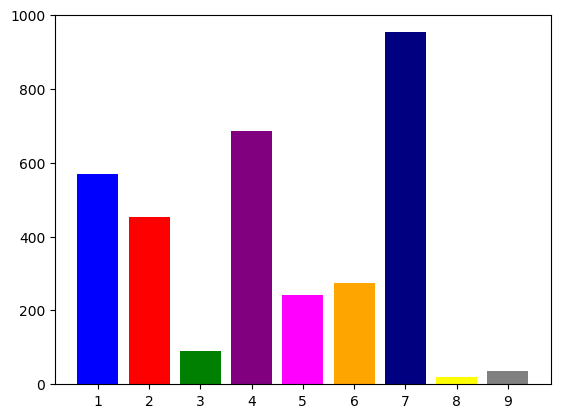

In [103]:
import matplotlib.pyplot as plt; plt.rcdefaults()

plt.bar([1,2,3,4,5,6,7,8,9], c.values(), color=["blue", "red", "green", "purple", "magenta", "orange", "navy", "yellow", "grey"], tick_label=[1,2,3,4,5,6,7,8,9])

### We see with the test data that there are 986 genes, with 279 unique. 945 unique variations, and 874 unique text articles. This marks a difference from the training data set where about 7.9% of the genes were unique and only slightly more than half of the text articles were unique.

In [23]:
Test.describe(include='all')

,Gene,Variation,Text
count,986,986,986
unique,279,945,874
top,TP53,Truncating Mutations,Among the best-studied therapeutic targets in ...
freq,40,18,24


### We now import most of the tools we use to build the classifier. Recall that we use a random forest classifier which is a part of pythons scikit-learn package.

In [26]:
import sklearn.ensemble

from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification

from sklearn.feature_extraction.text import CountVectorizer

from sklearn.feature_extraction.text import TfidfTransformer

import warnings
warnings.filterwarnings('ignore')

from sklearn import metrics

np.set_printoptions(threshold=np.nan)

In [27]:
from sklearn.pipeline import Pipeline

text_clf = Pipeline([('vect', CountVectorizer()),
                     ('tfidf', TfidfTransformer()),
                     ('clf', RandomForestClassifier()),
])

### We take a random 70% of the training data and use a grid search to find the best parameters to create our classifier. By taking a random 70% of the training data to build our classifier on we can use the remaining 30% of the data to test our classifier on to determine how good it is before we classify the actual test data. If we find that the classifier is not as good as we'd like it to be then we can fine-tune it and repeat.

In [28]:
from sklearn.model_selection import train_test_split

X_train, X_test = train_test_split(Train, train_size=.7)

In [29]:
from sklearn.grid_search import GridSearchCV

parameters = {'vect__ngram_range': [(1, 1), (1, 2)],
              'tfidf__use_idf': (True, False),
              'clf__max_depth': (None, 11,12)
}

In [30]:
gs_clf = GridSearchCV(text_clf, parameters, n_jobs=1)

In [31]:
gs_clf = gs_clf.fit(X_train['Text'], X_train['Class'])

In [39]:
predicted = gs_clf.predict(X_test['Text'])

metrics.confusion_matrix(X_test['Class'], predicted)

array([[ 81,   4,   2,  29,   7,  12,  26,   0,   0],
       [ 10,  59,   0,   7,   4,   0,  60,   0,   0],
       [  2,   0,   6,   9,   2,   0,  12,   0,   0],
       [ 34,   4,   1, 147,   5,   3,  18,   0,   0],
       [ 19,   1,   3,   8,  28,   4,  12,   0,   0],
       [  9,   4,   0,   4,   5,  54,  10,   0,   0],
       [  6,  23,   2,  11,   5,   1, 230,   0,   0],
       [  1,   1,   0,   1,   0,   0,   0,   1,   1],
       [  1,   0,   0,   2,   0,   0,   3,   0,   3]])

### To interpret the confusion matrix we note that each row corresponds to a class. The rows are the actual classes and the columns are the predicted classes. That means that in row 3 column 7 we observe that there were 12 items in class 3 that the classifier predicted to be in class 7. We also have that every number along the diagonal means that the classifier guessed the class correctly. We see that classes 1, 2, 4, and 7 are predicted frequently compared to classes 3, 5, 6, 8, and 9. This should make sense since we saw that these are the classes that appear the most in the data. Further note that class 8 was only predicted once and it turned out to be correct. 



### As discussed in the introduction, Kaggle scores the predictions based on log-loss. We can calculate the log-loss on our "test" sample which we pulled from 30% of the training data. As can be seen below we have a log-loss of 4.065.

In [50]:
metrics.log_loss(X_test['Class'], gs_clf.predict_proba(X_test['Text']))

4.065640641565067

In [101]:
Answer = gs_clf.predict_proba(Test['Text'])

### This was submitted on Kaggle to find that the log-loss on some subset of the data was calculated to be 5.085, which is only slightly higher than the log-loss we calculated on the known data. 


# Conclusion

#### <ol> By using a random forest classifier and a grid search consisting of 3 parameters with no more than 3 subparameters to choose from each we predicted the probability of classes of some subset of 986 genes / variations based on associated text data with a log-loss of 5.085. This is only slightly higher than our log-loss score on the testing subset of the training data. This of course is not a great log-loss score but considering the different nature of the actual test data it is good to see that it scores similar to the data where we did know the class. Read below for what we could have done to fine tune our algorithm if we were to work more on this problem.
    
# **Alternative Approaches:**

   #### <ol> After reading more discussion of the problem it appeared as if the actual test data was different enough from the training data so as to make the problem not necessarily the most well-posed. For that reason we did not put into practice the following approaches. If we were to continue working on this problem some approaches that would be interesting to consider would be to look at several different classifiers such as a support vector machine, which is also very popular for text classification. We could also have fine tuned our classifier with a stronger gridsearch, which is computationally expensive. Further we could have taken stronger consideration of the gene / variation into our classifier. For example we could have cut each text document to contain only 100 words to the left and right of any given mention of the gene / variation in consideration for that article. This may have made the computations less expensive and cut out some less useful information.